<b>Eric Sciullo </br>
Open Lab 4 </br>
CSCI 4850/5850 Neural Networks</b>

In [1]:
import keras
import keras.backend as K
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import SVG

Using TensorFlow backend.


In [2]:
# MNIST images are 28x28 pixels
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

# Digits 0-9
num_classes = 10
latent_dim = 100

In [3]:
# Generator is an inverse convolutional network for creating fake images

# input layer for noise
noise = keras.layers.Input(shape=(latent_dim,))

#input layer for class label
label = keras.layers.Input(shape=(1,), dtype='int32')

label_embedding = keras.layers.Flatten()(keras.layers.Embedding(num_classes, 100)(label))

# multiply noise by label embedding for generator input
generator_input = keras.layers.multiply([noise, label_embedding])

# hidden layers and structure
generator_hidden = keras.layers.Dense(128 * 7 * 7, activation='relu', input_dim=latent_dim)(generator_input)
generator_hidden = keras.layers.Reshape((7, 7, 128))(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.UpSampling2D()(generator_hidden)
generator_hidden = keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.UpSampling2D()(generator_hidden)
generator_hidden = keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
g_image = keras.layers.Conv2D(channels, kernel_size=3, padding='same', activation='tanh')(generator_hidden)

# finalize the model
generator = keras.Model([noise, label], g_image)
generator.compile(loss=['binary_crossentropy'],optimizer=keras.optimizers.Adam(0.0002,0.5))

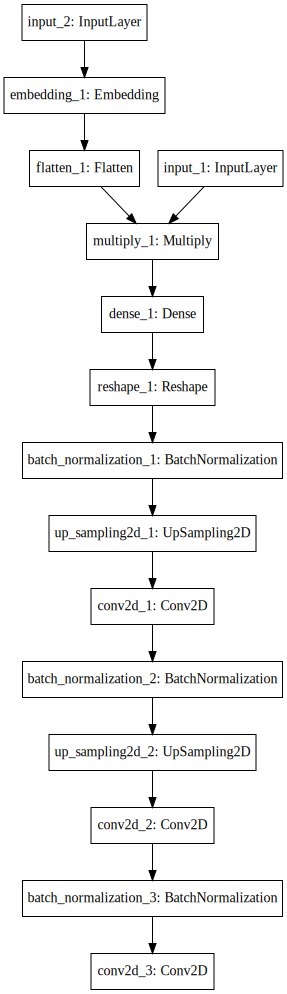

In [4]:
# generator model structure
SVG(model_to_dot(generator).create(prog = 'dot', format = 'svg'))

In [5]:
# Discriminator
# input for discriminator model is an image...
d_image = keras.layers.Input(shape=img_shape)

# hidden layers
discriminator_hidden = keras.layers.Conv2D(16, kernel_size=3, strides=2, input_shape=img_shape, padding='same')(d_image)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(discriminator_hidden)
discriminator_hidden = keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.BatchNormalization(momentum=0.8)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.BatchNormalization(momentum=0.8)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.Flatten()(discriminator_hidden)

# outputs will be both a probability of being "real" and...
valid = keras.layers.Dense(1, activation='sigmoid')(discriminator_hidden)
# a probability of what class (with fakes having a unique class)
target_label = keras.layers.Dense(num_classes+1, activation='softmax')(discriminator_hidden)

# finalize the model
discriminator = keras.Model(d_image, [valid, target_label])
discriminator.compile(loss=['binary_crossentropy','sparse_categorical_crossentropy'],
optimizer=keras.optimizers.Adam(0.0002,0.5),
metrics=['accuracy'])

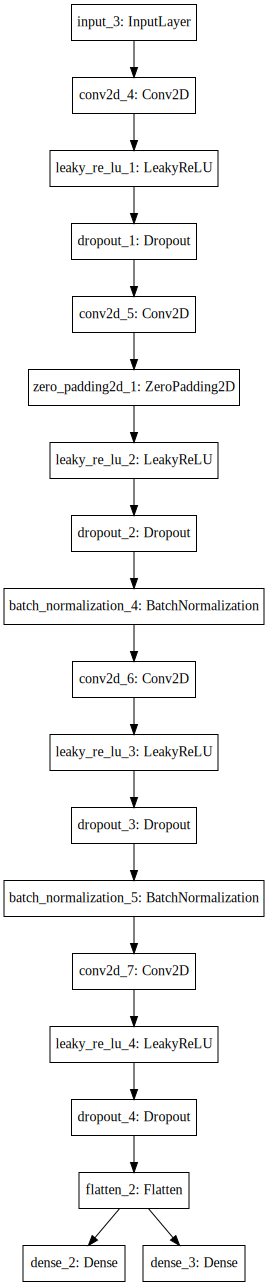

In [6]:
# discriminator model structure
SVG(model_to_dot(discriminator).create(prog = 'dot', format = 'svg'))

In [7]:
# combine generator and discriminator models
discriminator.trainable = False

# make the output of the generator feed into the discriminator
valid, target_label = discriminator(g_image)

# combined model has generator inputs and discriminator
combined = keras.Model([noise,label],[valid,target_label])
combined.compile(loss=['binary_crossentropy','sparse_categorical_crossentropy'],
optimizer=keras.optimizers.Adam(0.0002,0.5))

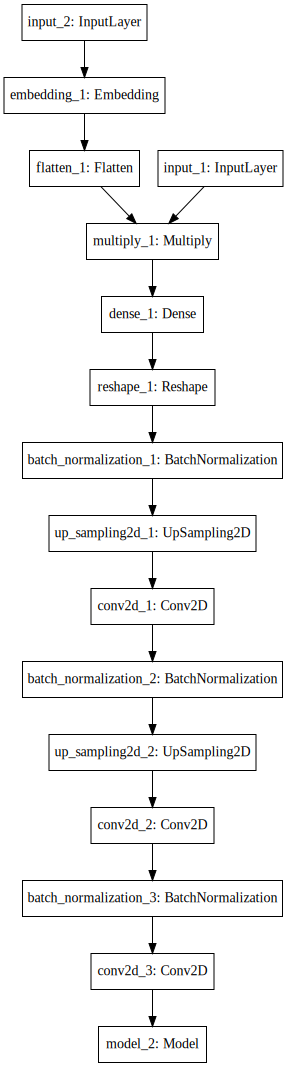

In [8]:
# combined model structure 
SVG(model_to_dot(combined).create(prog = 'dot', format = 'svg'))

In [9]:
# load MNIST data
(X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

# rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

y_train = y_train.reshape(-1, 1)

print(X_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000, 1)


In [10]:
# training Parameters
history = [[],[],[],[]]
batch_size = 32
half_batch_size = int(batch_size/2)
epochs = 20000

In [11]:
for epoch in range(epochs):
    # discriminator training
    idx = np.random.randint(0, X_train.shape[0], half_batch_size)
    real_images = X_train[idx]
    
    # generator noise for the generator to create some fakes
    noise = np.random.normal(0, 1, (half_batch_size, 100))
    
    # choose random value from 0-9 for generator to make
    sampled_labels = np.random.randint(0, 10, half_batch_size).reshape(-1, 1)
    
    # use the generator to make these images
    generated_images = generator.predict([noise, sampled_labels])
    
    # generate the real-fake target distinctions
    # reals are 1.0 (100% real)
    # fakes are 0.0 (0% real)
    valid = np.ones((half_batch_size, 1))
    fake = np.zeros((half_batch_size, 1))
    
    # use the labeled classes for the real images
    image_labels = y_train[idx]
    
    # assign the fake images to the "extra class" or "fake class"
    fake_labels = 10 * np.ones(half_batch_size).reshape(-1, 1)
    
    # train the discriminator
    d_loss_real = discriminator.train_on_batch(real_images, [valid, image_labels])
    d_loss_fake = discriminator.train_on_batch(generated_images, [fake, fake_labels])
    
    # calculate the average for an "overall" loss/accuracy for the discriminator
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # train the generator
    # noise 0-1
    noise = np.random.normal(0, 1, (batch_size, 100))
    
    # set the target as if the generated images were real
    valid = np.ones((batch_size, 1))
    
    # random digit 0-9 for generator to try and fake
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
    
    # train the generator
    g_loss = combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])
    
    # add results to history
    history[0] += [d_loss[0]]
    history[1] += [d_loss[3]]
    history[2] += [d_loss[4]]
    history[3] += [g_loss[0]]
    
    # view progress during training
    print("\r%d [Discriminator Loss: %f, Real/Fake-Acc.: %.2f%%, Classification-Acc: %.2f%%] [Generator Loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]),end='')

10237 [Discriminator Loss: 1.642878, Real/Fake-Acc.: 53.12%, Classification-Acc: 40.62%] [Generator Loss: 1.455534]

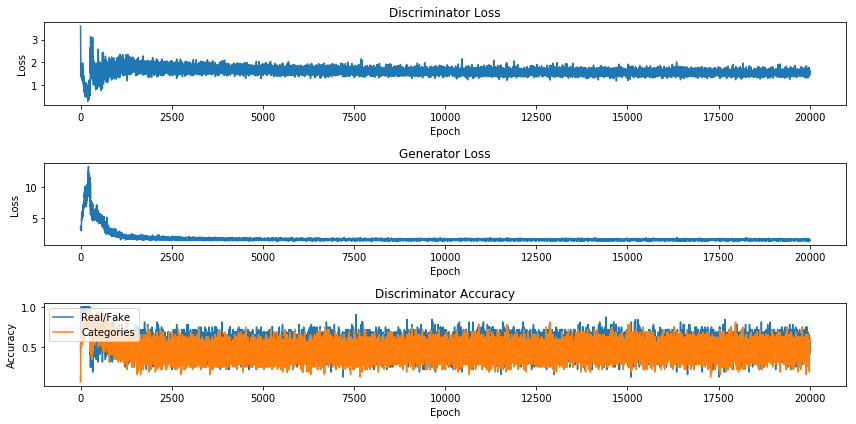

In [12]:
plt.figure(1,figsize=(12,6))
plt.subplot(311)
plt.plot(history[0])
plt.title('Discriminator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(312)
plt.plot(history[3])
plt.title('Generator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(313)
plt.plot(history[1])
plt.plot(history[2])
plt.title('Discriminator Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Real/Fake', 'Categories'], loc='upper left')
plt.tight_layout()
plt.show()

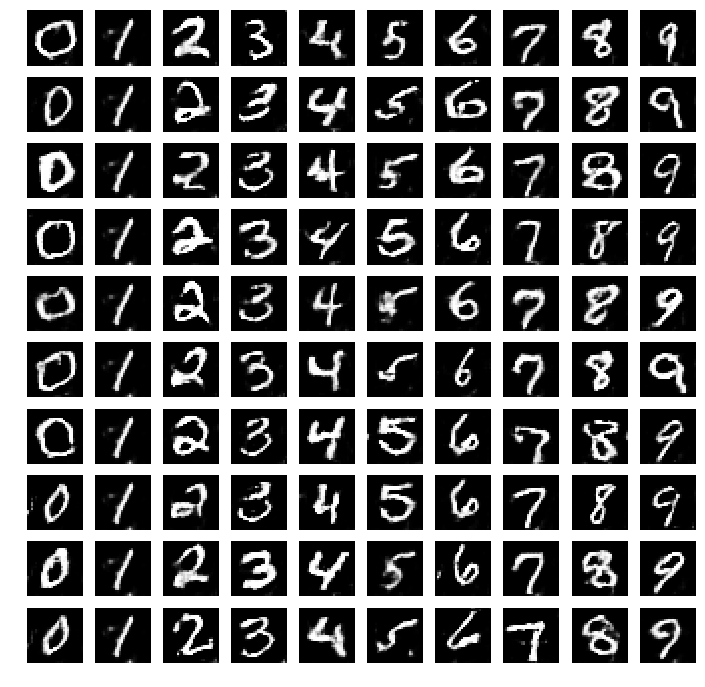

In [13]:
# testing
r, c = 10, 10
noise = np.random.normal(0, 1, (r * c, 100))
sampled_labels = np.array([num for _ in range(r) for num in range(c)])

# create some fakes
generated_images = generator.predict([noise, sampled_labels])

# rescale images
generated_images = 0.5 * generated_images + 1

# plot the fakes
fig, axs = plt.subplots(r, c)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(generated_images[count, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        count += 1
plt.show()